# Assignment 3 in System Genetics - Gil Sasson & Tomer Schweid

## Loading Modules

In [1]:
# Importing libraries
import pandas as pd
pd.options.mode.copy_on_write = True # A setting in pandas that suppresses warning in one of the operations so the notebook is cleaner
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import GEOparse
GEOparse.logger.set_verbosity("INFO") # Removing DEBUG information
from sklearn.feature_selection import f_regression
from statsmodels.stats.multitest import fdrcorrection
import os

## Global Variables

The basepair_cutoff is used in several places throughout the notebook. It is used both as a cutoff for cis/trans eQTL identification and for selecting representative SNPs.

In [2]:
# 2Mbp was defined in the assignment as the cutoff between cis-acting and trans-acting eQTL
# It is also used as threshold for 'proximity' for selecting representative SNPs
basepair_cutoff = 2000000 


## Part A: eQTL Analysis

### Preprocessing

#### 1. Downloading normalized data

We have chosen to use myeloid and liver data as our phenotype Infectious disease, immune function: H5N1 influenza A virus mortality rate 30 days after infection (Boon-Webby Trait 1) [% death], (phenotype_id = 787) and it is related to the immune system (myeloid) and the liver ([reference](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3886489/)).
First we will download the data and load it into pandas dataframes:

In [5]:
directory_path = 'data' # Path to data's directory, assuming it is in the working directory and that both files are in the same location

# Downloading the data
gse_myeloid = GEOparse.get_GEO(geo='GSE18067', destdir=directory_path)
gse_liver = GEOparse.get_GEO(geo='GSE17522', destdir=directory_path)

# Get the myeloid metadata
metadata_myeloid = pd.read_csv(directory_path + os.sep + "metadata myeloid.txt", sep="\t")
print("\nMyeloid data sample:")
print(metadata_myeloid.head().to_string())

# Get the liver metadata
metadata_liver = pd.read_csv(directory_path + os.sep + "metadata liver.txt", sep="\t")
print("\nLiver data sample:")
print(metadata_liver.head().to_string())

28-Sep-2024 20:56:28 INFO GEOparse - File already exist: using local version.
28-Sep-2024 20:56:28 INFO GEOparse - Parsing data/GSE18067_family.soft.gz: 
28-Sep-2024 20:56:33 INFO GEOparse - File already exist: using local version.
28-Sep-2024 20:56:33 INFO GEOparse - Parsing data/GSE17522_family.soft.gz: 



Myeloid data sample:
    GSM name                  Strain
0  GSM451699    BXD13 Myeloid batch1
1  GSM451700  BXD23 Erythroid batch1
2  GSM451701  BXD40 Erythroid batch1
3  GSM451702    BXD36 Myeloid batch1
4  GSM451703        BXD6 Stem batch1

Liver data sample:
    GSM name                   Strain
0  GSM436705  Liver_C57BL6J_M_B1_rep1
1  GSM436706  Liver_C57BL6J_M_B1_rep2
2  GSM436707       Liver_C57BL6J_F_B1
3  GSM436708         Liver_DBA2J_F_B1
4  GSM436709        Liver_B6D2F1_M_B1


In [6]:
# Get the gene identifiers for the myeloid data
gene_identifiers_df_myeloid = pd.DataFrame(gse_myeloid.gpls[list(gse_myeloid.gpls.keys())[0]].table)[["ID" , "Symbol"]]
print("\nMyeloid gene identifiers sample:")
print(gene_identifiers_df_myeloid.head().to_string())

# Get the gene identifiers for the liver data
gene_identifiers_df_liver= pd.DataFrame(gse_liver.gpls[list(gse_liver.gpls.keys())[0]].table)[["ID" , "GENE_NAME"]]
print("\nLiver gene identifiers sample:")
print(gene_identifiers_df_liver.head().to_string())

# Get the genotype data
genotype_df = pd.read_csv(directory_path + os.sep + "genotypes.txt")
print("\nGenotypes data sample:")
print(genotype_df.head().to_string())


Myeloid gene identifiers sample:
                   ID         Symbol
0       GI_38090455-S      LOC382362
1  scl0011717.2_283-S          Ampd3
2  scl52892.1.1_103-S  D830016O14Rik
3    scl0012946.2_3-S           Crry
4    scl18939.11_88-S            Ehf

Liver gene identifiers sample:
             ID                                                       GENE_NAME
0  A_51_P100021  human immunodeficiency virus type I enhancer binding protein 3
1  A_51_P100034                                         MIF4G domain containing
2  A_51_P100052                             SLIT and NTRK-like family, member 2
3  A_51_P100065                                      ligand of numb-protein X 1
4  A_51_P100084                                                             NaN

Genotypes data sample:
   0      Locus  Chr_Build37  Build37_position  BXD1  BXD2  BXD5  BXD6  BXD8  BXD9  BXD11  BXD12  BXD13  BXD14  BXD15  BXD16  BXD18  BXD19  BXD20  BXD21  BXD22  BXD23  BXD24  BXD25  BXD27  BXD28  BXD29  BXD30

#### 2, 6, 8. Annotating the Data with Gene Identifiers, Averaging Probes for the Same Gene and Individuals of the Same Strain.

The following helper functions will be used to parse the data:

In [7]:
# This helper function extracts the relevant data from the dataset provided by GSE
def parse_gse(gse):
  final_df = pd.DataFrame(columns=["GSM_name", "ID_REF", "VALUE"])
  sample_dfs = []

  # Iterate through each sample
  for gsm_name, gsm in gse.gsms.items():
      sample_data = {
          "GSM_name": gsm_name,
          "ID_REF": gsm.table["ID_REF"],
          "VALUE": gsm.table["VALUE"],
      }
      sample_df = pd.DataFrame(sample_data)
      sample_dfs.append(sample_df)
  final_df = pd.concat(sample_dfs, ignore_index=True)
  return final_df

# This helper function merges two dataframes
def merge(df1, df2, left_on, right_on):
    df1 = df1.merge(df2, left_on=left_on, right_on=right_on)
    return df1.drop(columns=[right_on, left_on])

# This helper function helps to filter only the samples
def filter_samples(df, cell_type):
    
    # Extract relevant cell types
    df = df[df["Strain"].str.contains(cell_type)]
    
    # Drop the technical replicates
    df = df[~df["Strain"].str.contains("Technical")]
    df = df[~df["Strain"].str.contains("rep")]

    return df

# This helper function pivots the table to have genes as rows and BxD strains as columns (also calculates the samples average)
def pivot_strains(df_merged, index):
    df_pivot = df_merged.pivot_table(columns="Strain", values="VALUE", index=index, aggfunc="mean")
    return df_pivot

# This helper function calculates the average across batches for each strain
def mean_batches(df, cell_type):
    
    # For myeloid dataset
    if cell_type == "Myeloid":

        # Extract strain names from column names
        df.columns = pd.MultiIndex.from_tuples([col.split(' ', 1) for col in df.columns], names=['strain', 'batch'])
        
        # Calculate the mean across batches for each strain
        mean_df = df.T.groupby(level='strain').mean()

    # For liver dataset
    elif cell_type == "Liver":
        
        # Mean across sex for each strain
        df.columns = pd.MultiIndex.from_tuples([col.split('_', 2) for col in df.columns], names=['liver','strain','sex'])
        
        # Calculate the mean across sex for each strain
        mean_df = df.T.groupby(level=['strain']).mean()
    
    return mean_df.T
    
# This helper function calculate the average in strains that contain multiple values (due to multiple measures)
def mean_strains(df_pivot):
    for strain in df_pivot.columns:
        if strain[-1].lower() == 'a':
            strain_name = strain[:-1]
            if strain_name + 'b' in df_pivot.columns:
                df_pivot[strain_name] = df_pivot[[strain, strain_name + 'b']].mean(axis=1)
                df_pivot = df_pivot.drop(columns=[strain, strain_name + 'b'])
            else:
                df_pivot[strain_name] = df_pivot[strain]
                df_pivot = df_pivot.drop(columns=[strain])
        elif strain[-1].lower() == 'b' :
            strain_name = strain[:-1]
            if strain_name + 'a' in df_pivot.columns:
                df_pivot[strain_name] = df_pivot[[strain, strain_name + 'a']].mean(axis=1)
                df_pivot = df_pivot.drop(columns=[strain, strain_name + 'a'])
    return df_pivot

Processing the tables to get the data in the requested format:

In [8]:
# Get the myeloid data
myeloid_df = parse_gse(gse_myeloid)
# Merge the metadata with the data
myeloid_df = merge(myeloid_df, metadata_myeloid, "GSM_name", "GSM name") 
# Merge the gene identifiers with the data
myeloid_df = merge(myeloid_df, gene_identifiers_df_myeloid, "ID_REF", "ID") 
# Filter the samples to include only the myeloid cells data
myeloid_df = filter_samples(myeloid_df, "Myeloid") 
# Reshape the data and average the probes for the same gene
myeloid_df = pivot_strains(myeloid_df, "Symbol") 
# Calculate the mean across batches for each strain
myeloid_df = mean_batches(myeloid_df, "Myeloid")
# Merge individuals of the same strain
myeloid_df = mean_strains(myeloid_df) 
print(myeloid_df.head().to_string())

strain             BXD1     BXD11     BXD12     BXD13     BXD14     BXD16     BXD18     BXD19      BXD2    BXD21B     BXD23     BXD27     BXD29     BXD31    BXD32B    BXD34B     BXD36     BXD40     BXD42      BXD6      BXD8      BXD9     BXD28     BXD33
Symbol                                                                                                                                                                                                                                                       
0610005A07Rik  6.439252  6.418787  6.461313  6.459590  6.392369  6.515128  6.446004  6.392673  6.263298  6.318342  6.343721  6.486555  6.409871  6.494575  6.391703  6.414189  6.339669  6.244116  6.322840  6.480558  6.522814  6.373272  6.529782  6.513522
0610005C13Rik  6.462294  6.556949  6.591845  6.573851  6.482562  6.616155  6.494463  6.553485  6.492469  6.409468  6.531997  6.587381  6.592969  6.446492  6.616821  6.510064  6.530035  6.591437  6.526547  6.454843  6.496264  6.586568  6.6

In [9]:
# Get the liver data
liver_df = parse_gse(gse_liver)
# Merge the metadata with the data
liver_df = merge(liver_df, metadata_liver, "GSM_name", "GSM name")
# Merge the gene identifiers with the data
liver_df = merge(liver_df, gene_identifiers_df_liver, "ID_REF", "ID")
# Drop technical replicates
liver_df = filter_samples(liver_df, "Liver")
# Reshape the data and average the probes for the same gene
liver_df = pivot_strains(liver_df, "GENE_NAME")
# Calculate the mean across sex for each strain
liver_df = mean_batches(liver_df, "Liver")
print(liver_df.head().to_string())

strain                                                                                             B6D2F1    BXD1  BXD11  BXD11TY   BXD12   BXD13   BXD14   BXD15   BXD16   BXD19    BXD2   BXD21  BXD23   BXD24   BXD28   BXD29   BXD31   BXD32   BXD33   BXD34   BXD36   BXD38   BXD39   BXD40   BXD42   BXD43   BXD44   BXD45   BXD48    BXD5   BXD51    BXD6   BXD60   BXD62   BXD69   BXD73   BXD77    BXD8   BXD85   BXD86    BXD9   BXD92  C57BL6J   DBA2J
GENE_NAME                                                                                                                                                                                                                                                                                                                                                                                                                                                        
1-acylglycerol-3-phosphate O-acyltransferase 1 (lysophosphatidic acid acyltransferase, alpha)"   1.2

#### 7. Choosing Representative SNPs

To choose representative SNPs we are choosing one SNP that contains the exact same data for all strains as other SNPs that are in its proximity. We choose the 2Mbp as a cutoff for "proximal" as it is defined in the assignment as the cis/trans cutoff.
This is the function that does this:

In [10]:
def select_representative_snps(df):
    duplicate_indices = [] # Initializing list of duplicate indices that are to be removed from the dataframe

    # Initializing a temporary dataframe that will have no position column so we could find duplicates (for strain data)
    temp_df = df.copy()
    temp_df.drop('Position', axis=1, inplace=True)
    
    # Searching for duplicate proximal strains
    for index, snp in df.iterrows():
        
        # Skipping SNPs that are pending deletion
        if index in duplicate_indices:
            continue
        
        # Dropping position column to find duplicates for strain data
        snp_data = snp.drop('Position')

        # Creating a list of indices of rows with matching data
        mask = (temp_df == snp_data).all(axis=1)
        matching_indices = temp_df.index[mask].tolist()
        matching_indices.remove(index) # Removing the index of the current SNP from the duplicate SNPs

        # Creating a list of indices that are proximal
        indices_in_range = df.index[(df['Position'] >= (df.at[index, 'Position'] - basepair_cutoff)) & 
                                    (df['Position'] <= (df.at[index, 'Position'] + basepair_cutoff))].tolist()
        
        # Adding relevant indices to the list of those that are to be removed
        for idx in matching_indices:
            
            # If the row is both identical and in range, it is a duplicate that we want to delete
            if idx in indices_in_range:
                duplicate_indices.append(idx)

    # Removing duplicates
    df.drop(duplicate_indices, inplace=True)
    
    return df

Choosing representative SNPs for both datasets:

In [11]:
# Extracting the relevant strains
relevant_strains = genotype_df.columns[4:] # Ignoring metadata (ID, Locus, Chromosome and Position are columns 0-3)
total_snps = genotype_df.shape[0] # Extracting the total number of SNPs

Myeloid dataset:

In [12]:
# Filter the relevant strains to include only those present in myeloid_df
filtered_strains_myeloid = [col for col in relevant_strains if col in myeloid_df.columns]

# Select the filtered columns from myeloid_df
myeloid_df = myeloid_df.loc[:, filtered_strains_myeloid]

# Get only the strains present in myeolid_df from the genotype data
representative_snps_myeloid = genotype_df[filtered_strains_myeloid]

# Adding position information
representative_snps_myeloid['Chromosome'] = genotype_df['Chr_Build37']
representative_snps_myeloid['Position'] = genotype_df['Build37_position']

# Chosing representative SNPs
representative_snps_myeloid = select_representative_snps(representative_snps_myeloid)
representative_snps_myeloid.drop(['Chromosome', 'Position'], axis=1, inplace=True)

print(f"The number of duplicate SNPs is: {total_snps - representative_snps_myeloid.shape[0]}")
print(f"We have {representative_snps_myeloid.shape[0]}/{total_snps} representative SNPs for the myeloid dataset")

The number of duplicate SNPs is: 2598
We have 1198/3796 representative SNPs for the myeloid dataset


Liver dataset:

In [13]:
# Filter the relevant strains to include only those present in liver_df
filtered_strains_liver = [col for col in relevant_strains if col in liver_df.columns]

# Select the filtered columns from liver_df
liver_df = liver_df.loc[:, filtered_strains_liver]

# Get only the strains present in liver_df from the genotype data
representative_snps_liver = genotype_df[filtered_strains_liver]

# Adding position information
representative_snps_liver['Chromosome'] = genotype_df['Chr_Build37']
representative_snps_liver['Position'] = genotype_df['Build37_position']

# Chosing representative SNPs
total_snps = representative_snps_liver.shape[0]
representative_snps_liver = select_representative_snps(representative_snps_liver)
representative_snps_liver.drop(['Chromosome', 'Position'], axis=1, inplace=True)

print(f"The number of duplicate SNPs is: {total_snps - representative_snps_liver.shape[0]}")
print(f"We have {representative_snps_liver.shape[0]}/{total_snps} representative SNPs for the liver dataset")

The number of duplicate SNPs is: 2173
We have 1623/3796 representative SNPs for the liver dataset


#### 3-5. Removing Genes with No Gene Identifier, Low Variance, and Low Maximum Expression

Myeloid dataset:  
We chose thresholds of 1/5 of the average variance and 1 below the average maximum expression value

In [14]:
# Filtering out genes with no gene identifier
myeloid_df_filtered = myeloid_df.dropna()

# Filtering out genes with low variance
row_variance = myeloid_df_filtered.var(axis=1)
average_variance = row_variance.mean()
print(f"The average variance is: {round(average_variance, 3)}")
myeloid_df_filtered = myeloid_df_filtered[row_variance > average_variance/5]

# Filtering out the genes with low maximum expression
row_max = myeloid_df_filtered.max(axis=1)
average_max = row_max.mean()
print(f"The average maximum expression value is: {round(average_max, 3)}")
myeloid_df_filtered = myeloid_df_filtered[row_max > average_max-1]
print(f"The number of genes before filtering is: {len(myeloid_df)} \nThe number of genes after filtering is: {len(myeloid_df_filtered)}")
myeloid_df_filtered

The average variance is: 0.044
The average maximum expression value is: 8.124
The number of genes before filtering is: 33718 
The number of genes after filtering is: 12348


strain,BXD1,BXD2,BXD6,BXD8,BXD9,BXD11,BXD12,BXD13,BXD14,BXD16,...,BXD19,BXD23,BXD27,BXD28,BXD29,BXD31,BXD33,BXD36,BXD40,BXD42
Symbol,,,,,,,,,,,,,,,,,,,,,
0610005H09Rik,6.960774,6.896540,7.562560,7.577809,7.829545,7.096886,7.711693,7.647623,7.651882,7.734397,...,7.631427,7.658030,7.765902,7.516431,7.733955,7.371241,7.651062,8.094586,8.252535,7.375777
0610005K03Rik,7.661794,7.666384,7.928899,7.988844,7.882973,7.659268,7.786213,7.787414,8.152209,8.030581,...,8.056267,7.920657,7.900948,7.781489,7.869633,7.581931,7.780241,7.908074,7.922678,7.836622
0610006I08Rik,8.875240,8.762721,9.421045,8.825492,9.091117,8.499736,9.129117,9.026674,8.602553,9.043345,...,8.777753,8.992152,8.907506,8.954717,8.716598,9.047889,8.801046,9.174790,8.924503,8.853475
0610006K04Rik,9.438693,9.243386,9.756049,9.374630,9.571306,9.340358,9.737258,9.855637,9.487117,9.800445,...,9.639080,9.743345,9.511634,9.790793,9.644615,9.646601,9.608166,9.681018,9.686598,9.459321
0610007A15Rik,7.602563,7.594103,7.850640,7.270924,7.622434,7.248914,7.546615,7.635080,7.623268,7.470072,...,7.693499,7.398174,7.427836,7.338654,7.455102,7.478714,7.635977,7.645716,7.319945,7.532734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mt-Nd4l,6.800670,7.159055,6.593207,6.660424,7.026090,7.654506,7.118404,6.574639,6.724822,6.741406,...,6.802272,6.831745,6.748640,6.783981,6.841271,6.920461,6.876898,6.697217,7.195945,6.653497
mt-Nd5,7.371511,7.593758,9.076073,9.447079,9.723641,9.590084,9.633232,9.732749,9.687021,9.702809,...,9.484752,9.512541,9.977413,9.196164,9.939603,9.575497,9.582638,10.794218,11.290422,9.720897
mt-Nd6,6.862807,7.181001,6.844717,6.735821,7.279028,7.084729,7.019636,6.774974,6.739732,6.578148,...,6.708698,6.707093,6.655872,6.608916,6.926962,6.695424,6.711797,6.594362,6.766707,6.682835


Liver dataset:  
We chose thresholds of 1/3 of the average variance and 1.5 below the average maximum expression value

In [15]:
# Filtering out genes with no gene identifier
liver_df_filtered = liver_df.dropna()

# Filtering out genes with low variance
row_variance = liver_df_filtered.var(axis=1)
average_variance = row_variance.mean()
print(f"The average variance is: {round(average_variance, 3)}")
liver_df_filtered = liver_df_filtered[row_variance > average_variance/3]

# Filtering out the genes with low maximum expression
row_max = liver_df_filtered.max(axis=1)
average_max = row_max.mean()
print(f"The average maximum expression value is: {round(average_max, 3)}")
liver_df_filtered = liver_df_filtered[row_max > average_max-1.5]
print(f"The number of genes before filtering is: {len(liver_df)} \nThe number of genes after filtering is: {len(liver_df_filtered)}")
liver_df_filtered

The average variance is: 0.055
The average maximum expression value is: 0.288
The number of genes before filtering is: 17917 
The number of genes after filtering is: 10949


strain,BXD1,BXD2,BXD5,BXD6,BXD8,BXD9,BXD11,BXD12,BXD13,BXD14,...,BXD48,BXD51,BXD60,BXD62,BXD69,BXD73,BXD77,BXD85,BXD86,BXD92
GENE_NAME,,,,,,,,,,,,,,,,,,,,,
"1-acylglycerol-3-phosphate O-acyltransferase 1 (lysophosphatidic acid acyltransferase, alpha)""",1.7480,1.1440,0.8800,1.2030,1.7245,1.1540,2.243,1.2085,1.9485,0.9215,...,0.8665,0.9135,1.0820,0.9410,1.2765,0.7425,1.4360,1.3890,1.4395,1.3800
"1-acylglycerol-3-phosphate O-acyltransferase 2 (lysophosphatidic acid acyltransferase, beta)",1.7625,1.8615,1.7190,1.6200,2.0670,1.2430,1.905,1.5790,1.9415,1.3830,...,2.1070,1.9635,1.5355,1.7440,1.9495,1.4490,1.8260,1.7725,1.8180,1.7840
1-acylglycerol-3-phosphate O-acyltransferase 3,0.7030,0.2645,0.6325,0.3815,0.6770,0.5405,0.508,0.5605,0.3715,0.2740,...,0.2860,0.3145,0.5700,0.5715,0.4090,0.2680,0.4305,0.3760,0.4680,0.2110
"1-acylglycerol-3-phosphate O-acyltransferase 5 (lysophosphatidic acid acyltransferase, epsilon)",-0.6520,-0.1725,-1.1295,-0.4600,-0.4900,-0.5690,-1.477,-0.5300,-1.1370,-0.8910,...,-0.5345,-0.7830,-1.2535,-0.7695,-1.6545,-1.7400,-0.6750,-1.8610,-0.6505,-0.6770
"1-acylglycerol-3-phosphate O-acyltransferase 6 (lysophosphatidic acid acyltransferase, zeta)",0.8450,0.7320,1.1730,0.9065,1.1170,1.6770,1.267,1.2195,1.4020,0.9095,...,0.8305,1.1930,0.9895,1.6265,1.3075,1.7400,0.9195,1.2785,0.9790,1.3175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zona pellucida like domain containing 1,-0.1685,-0.1325,-0.4075,-0.3370,0.0940,0.0930,-0.153,-0.1950,-1.0575,-0.0735,...,-0.1560,-0.1410,-0.0850,-0.1955,0.0140,-0.1100,-0.3550,-0.1725,-0.3360,-0.1780
zonadhesin,0.2415,0.3035,0.2125,0.3725,0.2090,0.7185,0.438,0.2925,0.2875,0.3600,...,0.3075,0.2205,0.2730,0.2175,0.0630,0.3440,0.0840,0.2685,0.1960,0.0780
zyg-11 homolog A (C. elegans),0.4280,0.8640,0.2355,0.3880,0.6840,0.5690,0.728,0.3185,0.2415,0.6095,...,0.4615,0.5400,0.3875,0.5035,0.5350,0.2815,0.7390,0.3355,0.6170,0.6635


#### Running Association Tests for the Genes and Representative SNPs

The following helper functions run the association test, and correct for multiple tests:

In [16]:
def association_test(df, snps):
    eQTLs = []
    for gene in df.index:
        results = f_regression(snps.T, df.loc[gene].T) # Run the regression
        p_values = results[1] # Get the p-values
        eQTLs.append({"gene": gene, "p_values": p_values})
    eQTLs_df = pd.DataFrame(eQTLs)
    return eQTLs_df

def correct_results(df, snps, alpha=0.05):
    
    # Correct the p-values for each dataset separately
    p_values_concatenated = np.concatenate(df['p_values'])
    corrected_p_values = fdrcorrection(p_values_concatenated)[1]
    
    # Reshape corrected p-values to match the original structure (genes × SNPs)
    corrected_p_values = corrected_p_values.reshape(len(df), -1)
    
    # Assign corrected p-values and significant SNPs
    df['corrected_p_values'] = list(corrected_p_values)
    
    # Map significant SNPs to genes
    df['significant_snps'] = [{genotype_df.loc[snps.index[j], 'Locus']: p 
                               for j, p in enumerate(row) if p < alpha}
                              for row in corrected_p_values]
    
    # Filter for genes with significant SNPs
    eQTLs_df = df[df['significant_snps'].map(len) > 0].reset_index(drop=True)
    
    return eQTLs_df

def eqtl_analysis(df, snps):
    
    # Run association test
    eQTLs = association_test(df, snps)

    # Correct p-values for multiple tests
    eQTLs_corrected = correct_results(eQTLs, snps)
    
    return eQTLs_corrected

Run the eQTL analysis:

In [17]:
eQTLs_myeloid = eqtl_analysis(myeloid_df_filtered, representative_snps_myeloid)
eQTLs_liver = eqtl_analysis(liver_df_filtered, representative_snps_liver)
print(eQTLs_myeloid.head().to_string())
print(eQTLs_liver.head().to_string())

            gene                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

### Report Your Results

We will work with what we previously found, but now we are only interested in the significant SNPs so we will change the dataframe structure a little. We will have a column ("snps data") that will contain a list of dictionaries, one for each significant SNP. Then, we will combine both dataframes in a superconstruct of a dictionary which contains the datasets and thier label so we could later run for loops on both instead of running the same code twice.

In [18]:
def extract_keys_values(row):
    
    # Extracting relevant information
    eQTLs_dict = row['significant_snps'] # Extracting dictionary of significant SNPs
    eQTLs = list(eQTLs_dict.keys()) # Extracting the name of the SNPs
    p_values = list(eQTLs_dict.values()) # Extracting the p-value of the SNPs
    
    # Creating a list of dictionaries, one for each SNP
    snps = [] # Initializing list
    for i in range(0, len(eQTLs)):
        snps.append({'snp':eQTLs[i], 'p_value':p_values[i]}) # Adding SNP dictionary to the list {'snp': SNP name, 'p_value': corrected p-value for that SNP}
    return snps

# Setting new columns according to desired state
eQTLs_myeloid['snps data'] = eQTLs_myeloid.apply(extract_keys_values, axis=1)
eQTLs_liver['snps data'] = eQTLs_liver.apply(extract_keys_values, axis=1)

# Dropping irrelevant columns
eQTLs_myeloid.drop(['p_values', 'corrected_p_values', 'significant_snps'], axis=1, inplace=True)
eQTLs_liver.drop(['p_values', 'corrected_p_values', 'significant_snps'], axis=1, inplace=True)

# Creating a dictionary with dataset name and dataframe
gene_eQTLs = {'Myeloid Dataset': eQTLs_myeloid, 'Liver Dataset': eQTLs_liver}

#### 1. How Many Different Significant eQTLs?

Let's count the significant eQTLs in each dataset (tissue)

In [19]:
def extract_snp_value(row, value):
    ''' This function returns a list of a given value (parameter) for all snps in "snps data" column'''
    snps_dict = row['snps data'] # Extracting the list of dictionaries
    snps_value = [] # Initializing list
    for snp in snps_dict:
        try:
            snps_value.append(snp[value]) # Adding the desired value to the list
        except:
            snps_value.append(np.nan) # Adding np.nan if the value doesn't exist for that SNP
    return snps_value

for dataset, df in gene_eQTLs.items():

    # Counting unique SNPs
    df['snps name'] = df.apply(extract_snp_value, value='snp', axis=1) # Adding a column with SNPs name
    snps_list = pd.Series(sum(df['snps name'].tolist(), [])) # Combining all lists of SNPs to a single list
    print(f"There are {len(snps_list.value_counts())} significant eQTLs in the {dataset.lower()}") # value_counts creates a list of keys and the amount of time they appear. len() therefore counts the number of unique values

There are 673 significant eQTLs in the myeloid dataset
There are 1435 significant eQTLs in the liver dataset


#### 1. How Many of them (eQTLs) are Cis-acting and Trans-acting?


First, let's add the chromosome and position of the significant SNPs we found:

In [20]:
def get_snps_genomic_position(snp_dict, lookup_df):
    for snp in snp_dict:
        
        # Searching for the SNP in the lookup_df (genotype_df)
        row = lookup_df[lookup_df['Locus'] == snp['snp']]

        # Add SNP location if we found it
        if not row.empty:
            snp['chromosome'] = row['Chr_Build37'].values[0]
            snp['position'] = row['Build37_position'].values[0]

    return snp_dict

for dataset, df in gene_eQTLs.items():
    
    # Adding chromosome and position for each SNP to the dictionaries in 'snps data'
    df['snps data'] = df['snps data'].apply(get_snps_genomic_position, lookup_df=genotype_df)
    print(df.head().to_string())

            gene                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         snps data                                                             snps name
0  0610009K11Rik  [{'snp': 'rs6404906', 'p_value': 0.03718891409653583, 'chromosome': 4, 'position': 133563658}, {'snp': 'rs13478001', 'p_value': 0.03718891409653583, 'chromosome': 4, 'position': 135998441}, {'snp': 'rs13478002', 'p_value': 0.009660813531567738, 'chromosome': 4, 'position': 136230564}, {'snp': 'rs6234904', 'p_value':

Now, we need to know the genomic location of each eQTL. We will use the provided MGI_Coordinates.Build37.rpt.txt file to find the genomic location

In [21]:
mgi_coordinates_df = pd.read_csv(directory_path + os.sep + "MGI_Coordinates.Build37.rpt.txt", sep="\t")
print(mgi_coordinates_df.head().to_string())

  MGI accession id marker type marker symbol                                 marker name representative genome id representative genome chromosome  representative genome start  representative genome end representative genome strand representative genome build  Entrez gene id
0        MGI:87853        Gene             a                                   nonagouti       OTTMUSG00000015981                                2                  154617138.0                154876748.0                            +               NCBI Build 37         50518.0
1        MGI:87854        Gene           Pzp                      pregnancy zone protein       OTTMUSG00000022212                                6                  128433591.0                128476738.0                            -               NCBI Build 37         11287.0
2        MGI:87855        Gene           Aal                   active avoidance learning                      NaN                              NaN                          

We are interested in the the 'representative genome chromosome', 'representative genome start' and 'representative genome end' columns. We can find ours according to the 'marker symbol' (myeloid) or 'marker name' (liver):

In [22]:
def get_genomic_position(gene, lookup_df):

    # Searching for the gene in the lookup_df (mgi_coordinates_df) using marker symbol (relevant for myeloid dataset)
    row = lookup_df[lookup_df['marker symbol'] == gene]

    # Add gene genomic position if we found it
    if not row.empty:
        chromosome = row['representative genome chromosome'].values[0]
        start_position = row['representative genome start'].values[0]
        end_position = row['representative genome end'].values[0]
    else:
        
        # Searching for the gene in the lookup_df (mgi_coordinates_df) using marker name (relevant for liver dataset)
        row = lookup_df[lookup_df['marker name'] == gene]
        
        # Add gene genomic position if we found it
        if not row.empty:
            chromosome = row['representative genome chromosome'].values[0]
            start_position = row['representative genome start'].values[0]
            end_position = row['representative genome end'].values[0]
        
        # Gene was not found in the lookup_df, adding np.nan for genomic location information
        else:
            chromosome = np.nan
            start_position = np.nan
            end_position = np.nan

    return pd.Series([chromosome, start_position, end_position])

for dataset, df in gene_eQTLs.items():

    # Adding gene genomic position
    df[['chromosome', 'start position', 'end position']] = df['gene'].apply(get_genomic_position, lookup_df=mgi_coordinates_df)
    df['chromosome'] = pd.to_numeric(df['chromosome'], errors='coerce') # chromosome values in mgi_coordinates are strings - converting them to numbers
    df = df[['gene', 'chromosome', 'start position', 'end position', 'snps data']] # Reordering columns
    gene_eQTLs[dataset] = df # Updating superconstruct with reordered columns
    print(df.head().to_string())

            gene  chromosome  start position  end position                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         snps data
0  0610009K11Rik         NaN             NaN           NaN  [{'snp': 'rs6404906', 'p_value': 0.03718891409653583, 'chromosome': 4, 'position': 133563658}, {'snp': 'rs13478001', 'p_value': 0.03718891409653583, 'chromosome': 4, 'position': 135998441}, {'snp': 'rs13478002', 'p_value': 0.009660813531567738, 'chromosome': 4, 'position': 136230564}, {'snp': 'rs623490

As we can see, we have genes that we didn't find thier position. To answer this question we will drop them (but we will use them in following questions):

In [23]:
def cis_or_trans_eqtl(row):
    
    # Extracting information
    gene_chromosome = row['chromosome'] # Extracting gene chromosome
    gene_start_position = row['start position'] # Extracting gene base pair position
    gene_end_position = row['end position'] # Extracting gene base pair position

    for snp in row['snps data']:
        position_distance = min(abs(gene_start_position - snp['position']), abs(gene_end_position - snp['position']))
    
        # If gene location is unknown, snp cis/trans activitity is unknown
        if pd.isna(gene_chromosome):
            snp['is cis?'] = np.nan
            position_distance = np.nan
    
        # If gene and SNP are not on the same chromosome - it is trans
        elif gene_chromosome != snp['chromosome']:
            snp['is cis?'] = False
            position_distance = np.nan
    
        # If gene and SNP are on the same chromosome, and are seperated by more than "basepair_cis_trans_cutoff" basepairs - it is trans
        elif position_distance > basepair_cutoff:
            snp['is cis?'] = False
    
        # Otherwise, it is a cis
        else:
            snp['is cis?'] = True
    
        #snp['distance'] = position_distance  # Uncomment for DEBUG
    return row['snps data']

for dataset, df in gene_eQTLs.items():

    # Adding 'is cis?' key to the dictionary of each SNP in 'snps data'
    df['snps data'] = df.apply(cis_or_trans_eqtl, axis=1)
    #gene_eQTLs[dataset] = df
    df['is snps cis?'] = df.apply(extract_snp_value, value='is cis?', axis=1) # Adding a column with "is cis?" SNP list
    
    # Counting eQTLs type
    snps_list = pd.Series(sum(df['is snps cis?'].tolist(), [])) # Combining all lists of SNPs to a single list
    value_counts = snps_list.value_counts(dropna=False) # Counting cis-acting, trans-acting, and unknown eQTLs
    print(f"{dataset}:")
    try:
        print(f'There are {value_counts[True]} cis-acting eQTLs and {value_counts[False]} trans-acting eQTLs.',
                f'Could not discern for {value_counts[np.nan]} eQTLs due to unknown location.')
    
    # If one of the values (True, False or np.nan) is not present at all, print the value_counts without reformatting
    except:
        print(value_counts)

Myeloid Dataset:
There are 394 cis-acting eQTLs and 961 trans-acting eQTLs. Could not discern for 1061 eQTLs due to unknown location.
Liver Dataset:
There are 1799 cis-acting eQTLs and 4910 trans-acting eQTLs. Could not discern for 2202 eQTLs due to unknown location.


#### 2. What is the Distribution of Number of Genes Associated With a Given eQTL?

Our current dataframes are organized on a gene basis with related SNPs (eQTLs). The following questions are asked about the eQTLs, and it will be easier to answer them if the data is organized where the rows are eQTLs (SNPs) based (with related genes in other columns). Let's create the new dataframes:

In [24]:
def pivot_to_snp_dataframe(gene_eQTL_df):
    snp_to_genes = {}

    # Iterate over each row (gene) in the dataframe
    for _, row in gene_eQTL_df.iterrows():
        gene = row['gene']
        snps_data = row['snps data']

        # For each SNP related to this gene, add the gene to the list of associated genes
        for snp_data in snps_data:
            snp_name = snp_data['snp']
            if snp_name not in snp_to_genes:
                snp_to_genes[snp_name] = {
                    'snp data': snp_data,  # Store the SNP data
                    'associated genes': [] # Create a list of associated genes
                }
            snp_to_genes[snp_name]['associated genes'].append(gene) # Adding the current gene as related to the SNP

    # Create a DataFrame from the SNP mapping
    snp_rows = []
    for snp_name, snp_data in snp_to_genes.items():
        snp_rows.append({
            'snp': snp_name,
            'chromosome': snp_data['snp data']['chromosome'], 
            'position': snp_data['snp data']['position'],
            'associated genes': snp_data['associated genes']  # List of genes
        })
    snp_df = pd.DataFrame(snp_rows)
    return snp_df

# Creating SNP oriented dataframes from the gene oriented dataframes
snp_eQTLs = {} # Initialize a superconstruct
for dataset, df in gene_eQTLs.items():
    snp_df = pivot_to_snp_dataframe(df)
    snp_df['associated genes count'] = snp_df['associated genes'].apply(lambda x: len(x))
    snp_eQTLs[dataset] = snp_df
    print(snp_df.head().to_string())

          snp  chromosome   position                                                                          associated genes  associated genes count
0   rs6404906           4  133563658                [0610009K11Rik, 4931440N07Rik, AI838661, Cd52, Clcnka, Eya3, Sytl1, Tcea3]                       8
1  rs13478001           4  135998441                [0610009K11Rik, 4931440N07Rik, AI838661, Cd52, Clcnka, Eya3, Sytl1, Tcea3]                       8
2  rs13478002           4  136230564  [0610009K11Rik, 1110005F07Rik, 4930523M17Rik, C79267, Casp9, Cd52, Clcnka, Padi2, Tcea3]                       9
3   rs6234904           4  138152372                    [0610009K11Rik, 1110005F07Rik, AI838661, C79267, Casp9, Clcnka, Padi2]                       7
4  rs13478021           4  140166294                    [0610009K11Rik, 1110005F07Rik, AI838661, C79267, Casp9, Clcnka, Padi2]                       7
             snp  chromosome  position                                                        

Now let's create a histogram of the requested distribution:

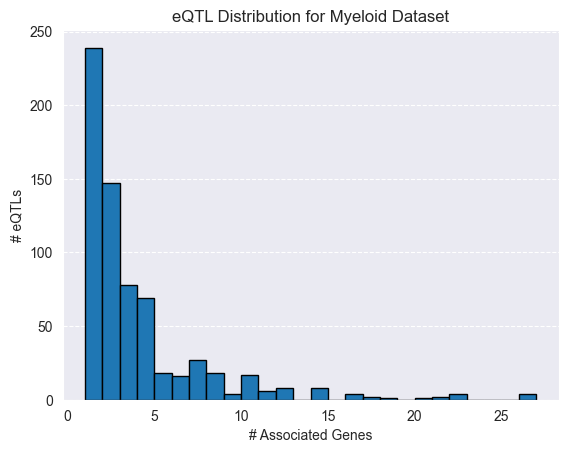

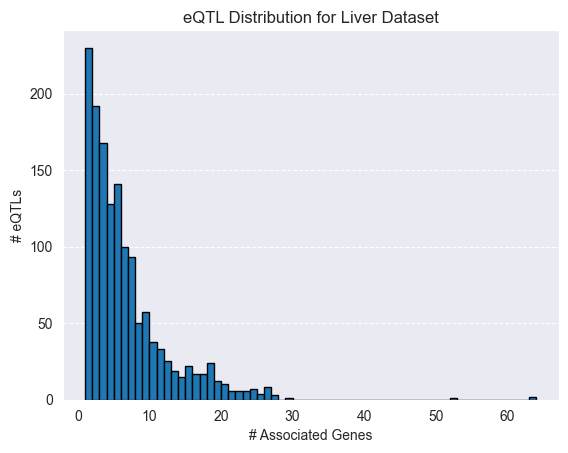

In [25]:
for dataset, df in snp_eQTLs.items():  
    
    # Making bin width to be 1
    bin_width = 1
    min_value = df['associated genes count'].min()
    max_value = df['associated genes count'].max()
    bins = np.arange(min_value - (min_value % bin_width), max_value + bin_width, bin_width) 
    
    # Plotting
    df['associated genes count'].hist(edgecolor='black', grid=False, bins=bins)
    plt.title(f'eQTL Distribution for {dataset}')
    plt.xlabel('# Associated Genes')
    plt.ylabel('# eQTLs')
    plt.grid(axis='y', linestyle='--')
    plt.show()

#### 3. Plot the Number of Genes Associated With Each eQTL Across the Genome

 In order to plot the location of genes/SNPs on the genome we will convert absolute basepair position to a relative position in the chromosome. For this we need to know what is the length (in basepairs) of each chromosome. Let's extract this information from the MGI_coordinates dataframe:

In [26]:
chromosomes_length_approximation = {}
for chromosome in range(1,21):
    chromosomes_length_approximation[chromosome] = mgi_coordinates_df[mgi_coordinates_df['representative genome chromosome'] == str(chromosome)]['representative genome end'].max()
chromosomes_length_approximation 

{1: np.float64(197117633.0),
 2: np.float64(181735792.0),
 3: np.float64(159598042.0),
 4: np.float64(155610501.0),
 5: np.float64(152453817.0),
 6: np.float64(149515484.0),
 7: np.float64(152509964.0),
 8: np.float64(131707632.0),
 9: np.float64(124041920.0),
 10: np.float64(129934435.0),
 11: np.float64(121831999.0),
 12: np.float64(121257179.0),
 13: np.float64(120284312.0),
 14: np.float64(125076349.0),
 15: np.float64(103440060.0),
 16: np.float64(98303132.0),
 17: np.float64(95235219.0),
 18: np.float64(90712659.0),
 19: np.float64(61333871.0),
 20: np.float64(166638958.0)}

Now let's plot the what we were asked:

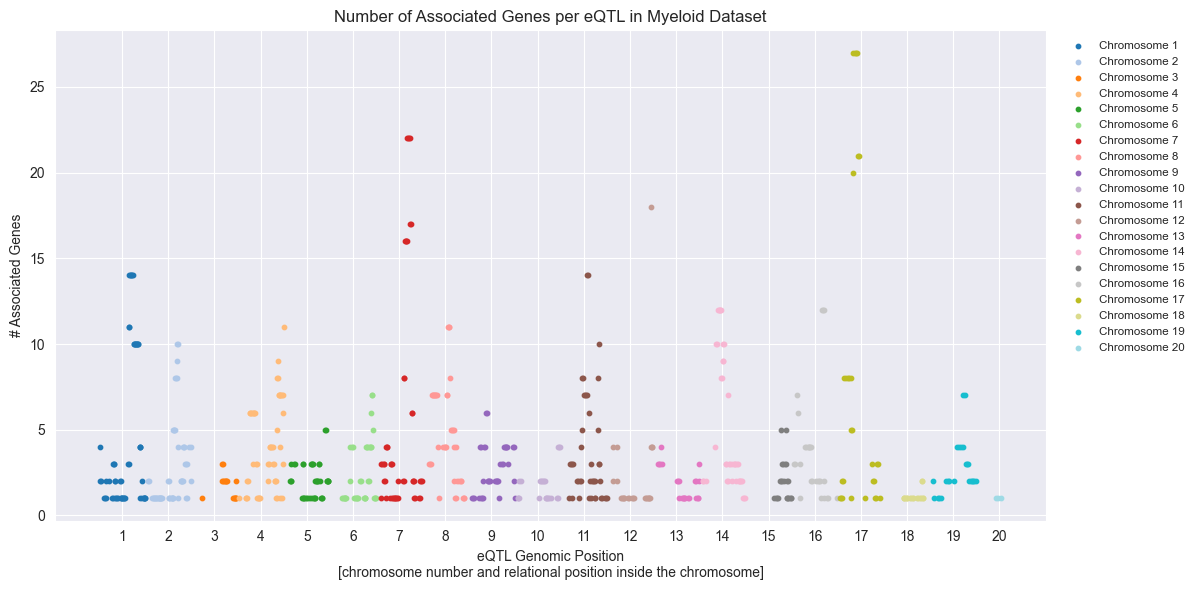

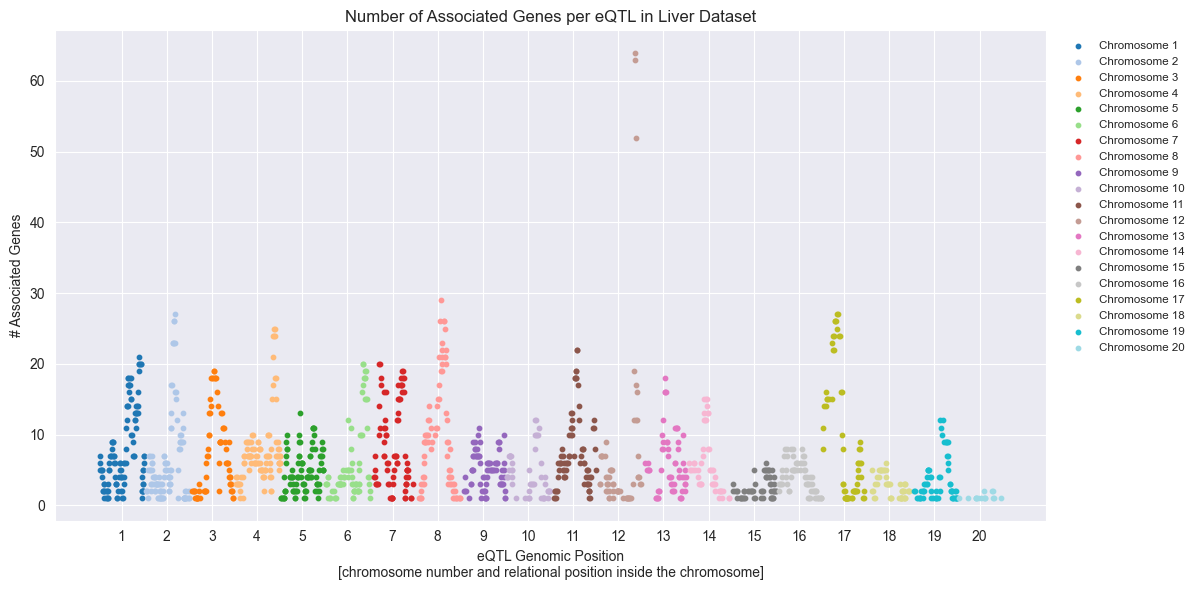

In [27]:
for dataset, df in snp_eQTLs.items():
    df['relative position'] = df.apply(lambda row: (row['position'] / chromosomes_length_approximation[row['chromosome']]), axis=1) # Calculating reltive position in the chromosome
    
    plt.figure(figsize=(12, 6)) # Initializing plot
    
    for chromosome in sorted(df['chromosome'].unique()):
        plot_data = df[df['chromosome'] == chromosome]
        chromosome = int(chromosome) # Converting chromosome from numpy.float64  to integer, relevant for the scatter parameters
        plot_data['plot position'] = plot_data['relative position'].apply(lambda x: (x + chromosome - 0.5)) # Adjusting plot position such that each SNP dot is presented on the right chromosome and with the relational position on the chromosome itself, each chromosome data is around that chromosome number in the plot
        chromosome_colors = plt.cm.tab20(np.linspace(0, 1, len(df['chromosome'].unique()))) # Define colors for chromosomes
        plt.scatter(plot_data['plot position'], plot_data['associated genes count'], color=chromosome_colors[chromosome-1],
                    s=10, label=f'Chromosome {chromosome}' if chromosome <= len(chromosome_colors) else "") # Plotting the dots

    # Customize the plot
    plt.title(f'Number of Associated Genes per eQTL in {dataset}')
    plt.xlabel('eQTL Genomic Position\n[chromosome number and relational position inside the chromosome]')
    plt.ylabel('# Associated Genes')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize='small', ncol=1, frameon=False)
    plt.tight_layout()
    plt.xticks(list(range(1, len(df['chromosome'].unique())+1)))
    plt.show()

#### 4. Compare the Distribution of Association P-values Scans Between Cis-Associated Genes and Trans-Associated Genes

We will create a histogram of p-values for cis and trans per dataset to compare the distributions

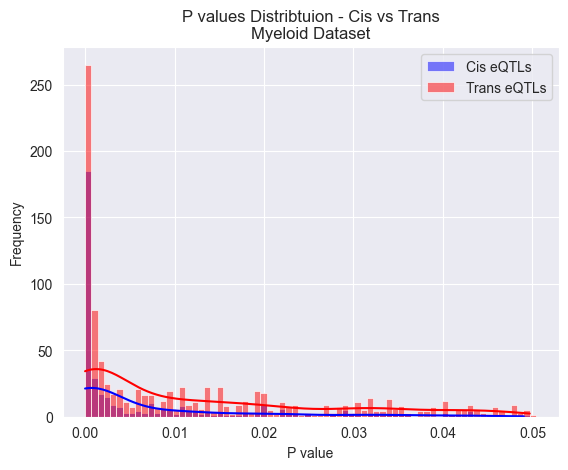

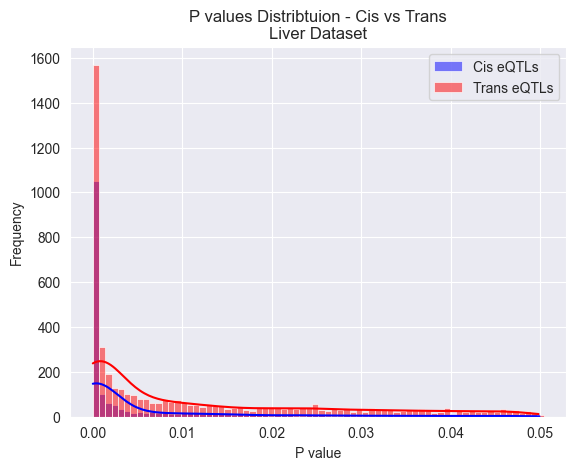

In [28]:
for dataset, df in gene_eQTLs.items():
    
    # Extracting cis and trans p values:
    temp_df = df # Working with temporary dataframe since we drop NaNs
    temp_df.dropna(inplace=True) # Dropping genes with unknown location (NaNs)
    cis_p_values = [] # Initializing list
    trans_p_values = [] # Initializing list
    
    # Adding SNPs p value to the relevant list
    for _, row in temp_df.iterrows():
        snps_data_series = pd.Series(row['snps data']) # Converting the list to pandas series to use logical indexing (according to is cis column)
        cis_snps = snps_data_series[row['is snps cis?']] # Extracting cis snps
        trans_snps = snps_data_series[[not x for x in row['is snps cis?']]] # Extracting trans snps
        for snp in cis_snps:
            cis_p_values.append(snp['p_value'])
        for snp in trans_snps:
            trans_p_values.append(snp['p_value'])
    
    # Plotting

    # Adjusting width
    bin_width = 0.0007
    min_value = min(cis_p_values + trans_p_values)
    max_value = max(cis_p_values + trans_p_values)
    bins = np.arange(min_value - (min_value % bin_width), max_value + bin_width, bin_width) 

    # Adding plot values
    sns.histplot(cis_p_values, bins=bins, color='blue', alpha=0.5, label='Cis eQTLs', kde=True)
    sns.histplot(trans_p_values, bins=bins, color='red', alpha=0.5, label='Trans eQTLs', kde=True)

    # Add labels and title
    plt.xlabel('P value')
    plt.ylabel('Frequency')
    plt.title(f"P values Distribtuion - Cis vs Trans\n{dataset}")

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

#### 5. Create a Scatter Plot Visualization (as seen in lecture)

First, let's add a relative position to the genes:

In [29]:
for dataset, df in gene_eQTLs.items():
    df['relative position'] = df.apply(lambda row: (row['start position'] / chromosomes_length_approximation[row['chromosome']]), axis=1) # Calculating reltive position in the chromosome

Now we can plot what we are requested:

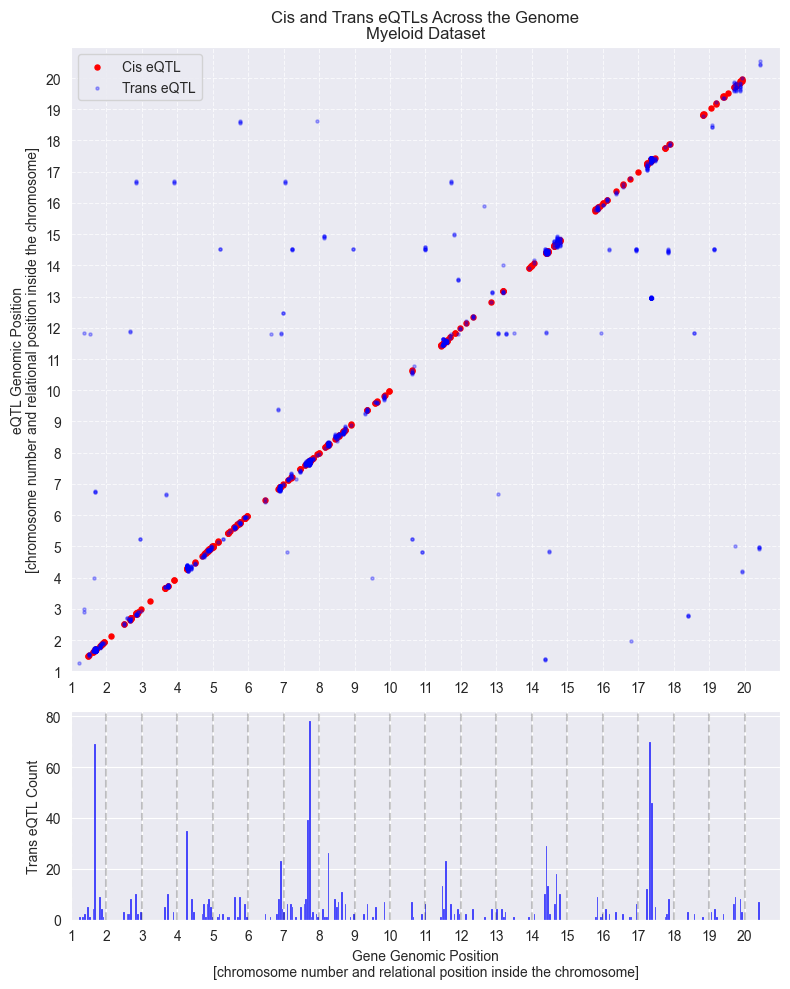

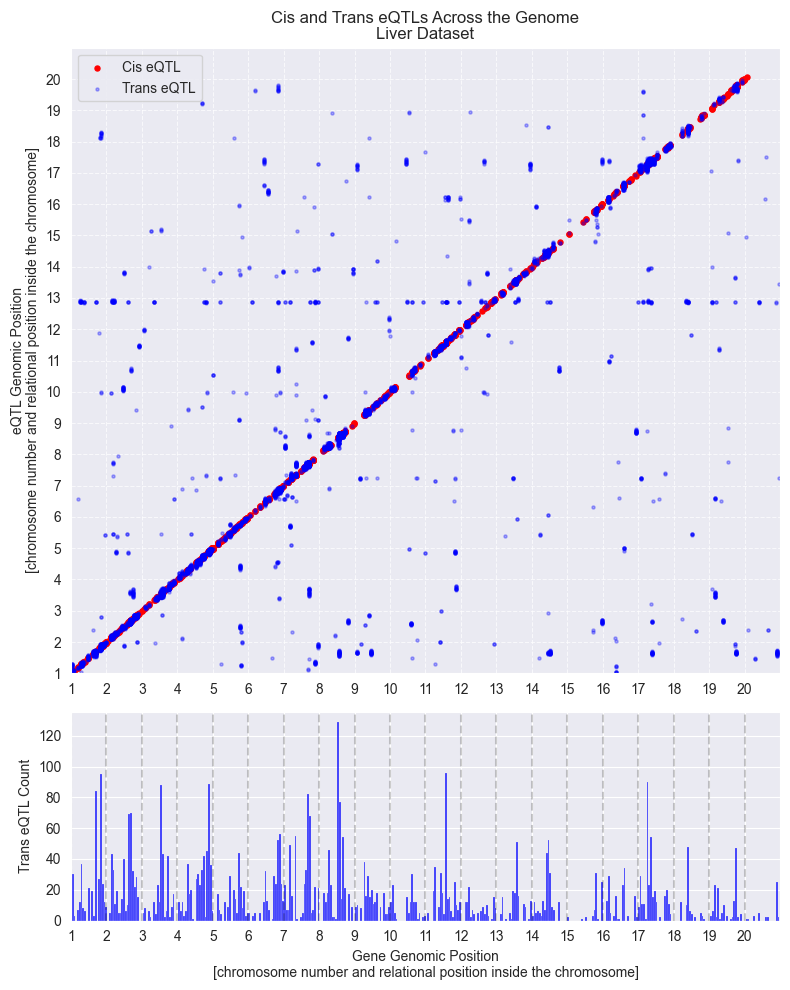

In [30]:
for dataset, df in gene_eQTLs.items():
    temp_df = df.copy()
    temp_df.dropna(inplace=True)
    
    # Initializing empty lists
    genes_position = []
    eqtls_position = []
    eqtls_type = []

    for _, row in temp_df.iterrows():
        gene_poistion = row['relative position'] + row['chromosome'] # Adjusting plot position such that each SNP dot is presented on the right chromosome and with the relational position on the chromosome itself, each chromosome data is around that chromosome number in the plot
        for snp in row['snps data']:
            snp_position = (snp['position'] / chromosomes_length_approximation[snp['chromosome']]) + snp['chromosome'] # Adjusting plot position such that each SNP dot is presented on the right chromosome and with the relational position on the chromosome itself, each chromosome data is around that chromosome number in the plot
            genes_position.append(gene_poistion)
            eqtls_position.append(snp_position)
            if snp['is cis?']:
                eqtls_type.append('cis')
            else:
                eqtls_type.append('trans')

    # Creating DataFrame for the plot
    plot_data = pd.DataFrame({'gene position': genes_position, 'eqtl position': eqtls_position, 'association type': eqtls_type})

    # Separate cis and trans associations
    cis_associations = plot_data[plot_data['association type'] == 'cis']
    trans_associations = plot_data[plot_data['association type'] == 'trans']

    # Configuring subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 10))

    # Scatter plot eQTLs
    ax1.scatter(cis_associations['gene position'], cis_associations['eqtl position'], color='red', s=13, label='Cis eQTL')
    ax1.scatter(trans_associations['gene position'], trans_associations['eqtl position'], color='blue', s=5, label='Trans eQTL', alpha=0.3)

    # Adding titles and axis labels
    ax1.set_ylabel('eQTL Genomic Position\n[chromosome number and relational position inside the chromosome]')
    ax1.legend()
    ax1.set_title(f'Cis and Trans eQTLs Across the Genome\n{dataset}')

    # Adding grid lines and x/y ticks
    chromosome_ticks = range(1, 21)
    ax1.set_xticks(chromosome_ticks)
    ax1.set_yticks(chromosome_ticks)
    ax1.grid(True, linestyle='--', alpha=0.7)  # Adds dashed grid lines
    
    # Setting the plot to start from the first chromosome (instead of 0)
    ax1.set_xlim(1, 21)
    ax1.set_ylim(1, 21)

   # Bar plot for trans eQTL count per locus
    sns.histplot(trans_associations['gene position'], bins=400, ax=ax2, color='blue')
    ax2.set_xlabel('Gene Genomic Position\n[chromosome number and relational position inside the chromosome]')
    ax2.set_ylabel('Trans eQTL Count')
    ax2.set_xticks(chromosome_ticks)
    ax2.set_xlim(1, 21) # Setting the plot to start from the first chromosome (instead of 0)
    for i in chromosome_ticks:
        ax2.axvline(x=i, color='black', linestyle='--', alpha=0.2)

    plt.tight_layout()
    plt.show()

## Part B: Combining Results

Loading the significant QTLs from assignment 2

In [31]:
significat_QTLs = pd.read_csv(directory_path + os.sep + "significant_QTLs.txt", sep=",")
print(significat_QTLs.head().to_string())

              SNP  Chromosome    Position   -log(p)         p  is_significant?  corrected_p
0       rs3699934           2  35957196.0  3.609513  0.000246             True     0.049098
1      rs13476435           2  37285190.0  3.609513  0.000246             True     0.049098
2       rs3709811           2  37512633.0  3.609513  0.000246             True     0.049098
3      rs13476448           2  39670020.0  3.609513  0.000246             True     0.049098
4  CEL-2_39972578           2  39868107.0  4.070538  0.000085             True     0.036797


### • Does Gene Expression Data Provide Any Added Value for the Identification of QTLs?

Let's checking which QTLs are also eQTLs:

In [32]:
snp_QTLs = {} # Creating a superconstruct for the QTLs
for dataset, df in snp_eQTLs.items():

    # Creating a list of SNPs that are significant in both QTL and eQTL analysis
    qtl_and_eqtl = []
    for qtl in significat_QTLs['SNP']:
        if qtl in df['snp'].to_list():
            qtl_and_eqtl.append(qtl)
    print(f'found {len(qtl_and_eqtl)}/{len(significat_QTLs["SNP"])} QTLs that are also eQTLs in the {dataset.lower()}')
    snp_QTLs[dataset] = qtl_and_eqtl

found 4/19 QTLs that are also eQTLs in the myeloid dataset
found 7/19 QTLs that are also eQTLs in the liver dataset


Since we chose representative SNPs, let's see if the QTLs we didn't find are within the range we defined to filter out:

In [33]:
for dataset, list in snp_QTLs.items():
    counter = 0
    for _, qtl in significat_QTLs.iterrows():
        # If QTL is eQTL
        if qtl['SNP'] in list:
            counter = counter + 1
        else:
            qtl_position = qtl['Position']
            qtl_chromosome = qtl['Chromosome']
            for found_qtl in list:
                found_qtl_row = significat_QTLs[significat_QTLs['SNP'] == found_qtl]
                found_qtl_chromosome = found_qtl_row.iloc[0]['Chromosome']
                found_qtl_position = found_qtl_row.iloc[0]['Position']
                # If QTL is near eQTL (basepair_cutoff)
                if (qtl_chromosome == found_qtl_chromosome) and (abs(qtl_position - found_qtl_position) < basepair_cutoff):
                    counter = counter + 1
                    break
    print(f'Found {counter}/{len(significat_QTLs["SNP"])} QTLs that are eQTLs or in proximity of eQTL in the {dataset.lower()}')

Found 16/19 QTLs that are eQTLs or in proximity of eQTL in the myeloid dataset
Found 19/19 QTLs that are eQTLs or in proximity of eQTL in the liver dataset


#### Exporting the Data for the Final Project

In [34]:
# Exporting eQTLs df
for dataset, df in snp_eQTLs.items():
    df.to_pickle(os.path.join(directory_path, f'eQTLs_{dataset}.pkl'))
# Exporting genes df
for dataset, df in gene_eQTLs.items():
    df.to_pickle(os.path.join(directory_path, f'genes_{dataset}.pkl'))
# Exporting analysis df
liver_df_filtered.to_csv(os.path.join(directory_path, 'analysis_liver.csv'), index=True)
myeloid_df_filtered.to_csv(os.path.join(directory_path, 'analysis_myeloid.csv'), index=True)